### Задание 1
Обучить любую модель классификации на датасете IRIS до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [169]:
X, y = load_iris(return_X_y=True)

In [170]:
X.shape

(150, 4)

Разобьем выборку на обучающую и тестовую. Обучим модель используя XGBClassifier (без предварительной оптимизации)

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [172]:
import xgboost as xgb

In [173]:
%%time

model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_test_pred = model_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {round(accuracy, 3)}")

[15:31:45] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.967
CPU times: user 1.11 s, sys: 92 ms, total: 1.21 s
Wall time: 239 ms


Реализуем метод главных компонент, а потом снова обучим модель

In [174]:
# Для начала масштабируем выборку
X_ = X.astype(float)

rows, cols = X_.shape

# центрирование — вычитание из каждого значения среднего по строке
means = X_.mean(0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_, axis=0)
for i in range(cols):
    for j in range(rows):
        X_[j][i] /= std[i]

In [175]:
# Найдём собственные векторы и собственные значения (англ. Eigenvalues)
 
covariance_matrix = X_.T.dot(X_)

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения в порядке убывания:
(437.77467247979905, array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654]))
(137.1045707202107, array([-0.37741762, -0.92329566, -0.02449161, -0.06694199]))
(22.01353133569719, array([-0.71956635,  0.24438178,  0.14212637,  0.63427274]))
(3.107225464292897, array([ 0.26128628, -0.12350962, -0.80144925,  0.52359713]))


In [176]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную, то есть накапливаемую, дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[72.96244541329986, 22.85076178670179, 3.668921889282866, 0.517870910715483]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


In [177]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [178]:
# Сформируем новую матрицу «объекты-признаки»
Z = X_.dot(W)

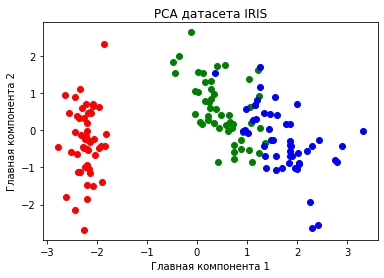

In [179]:
plt.figure()

for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y==i, 0], Z[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

Обучим новую модель

In [180]:
Z_train, Z_test, y_z_train, y_z_test = train_test_split(Z, y, test_size=0.2, random_state=1, stratify=y)

In [181]:
%%time

model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(Z_train, y_z_train)

y_z_test_pred = model_xgb.predict(Z_test)
accuracy = accuracy_score(y_z_test, y_z_test_pred)
print(f"Accuracy: {round(accuracy, 3)}")

[15:31:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.867
CPU times: user 1.34 s, sys: 119 ms, total: 1.46 s
Wall time: 285 ms


#### Вывод:
После применения PCA метрика качества снизилась.

Обучим модель используя RandomForestClassifier

In [182]:
from sklearn.ensemble import RandomForestClassifier

In [183]:
X, y = load_iris(return_X_y=True)

In [184]:
clf = RandomForestClassifier(max_depth=3, random_state=1)

Метрика до применения PCA:

In [185]:
clf.fit(X,y)
clf.score(X,y)

0.9666666666666667

После применения PCA:

In [186]:
clf.fit(Z,y)
clf.score(Z,y)

0.9466666666666667

После снижения размерности данных метрика качества ухудшилась.

### Задание 2
Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd()

Сформулировав принцип реализации метода главных компонент, нельзя не заметить его родство с _сингулярным разложением матриц — singular value decomposition, SVD_. Вспомним, что сингулярное разложение матрицы — это разложение вида:

$$X=UDV^{T},$$

где столбцы ортогональной матрицы $U$ — собственные векторы матрицы $XX^{T}$, столбцы ортогональной матрицы $V$ — собственные векторы матрицы $X^{T}X$, а на главной диагонали диагональной матрицы $D$ расположены собственные значения матриц $XX^{T}$ и $X^{T}X$, они равны и также называются сингулярными числами матрицы $X$.

Если число новых признаков $d$ равно старому числу признаков $n$, то можно приравнять разложения:

$$X=ZW=UDV^{T}.$$

Матрицы $W$ и $V^{T}$ состоят из собственных векторов матрицы $X^{T}X$, то есть они равны при $Z=UD$.

Получается, что метод опорных векторов в своём роде — «урезанная версия» сингулярного разложения, из которого убрали минимальные собственные значения с соответствующими собственными векторами. 
Таким образом, для реализации понижения размерности методом опорных векторов посредством SVD надо:
- найти сингулярное разложение вектора $X$;
- сформировать из столбцов матрицы $V$, соответствующих $d$ наибольшим сингулярным числам, матрицу весов $W$;
- получить новую матрицу «объекты-признаки», умножив исходную матрицу $X$ на матрицу весов $W$:

$$Z=XW.$$

In [187]:
X, y = load_iris(return_X_y=True)

In [188]:
X.shape

(150, 4)

In [189]:
def standard_scale(x):
    res = (x - x.mean(axis=0)) / x.std(axis=0)
    return res


X = standard_scale(X)

In [190]:
U, D, V = np.linalg.svd(X.T @ X)
U.shape, D.shape, V.shape

((4, 4), (4,), (4, 4))

In [191]:
U #собственные векторы матрицы  𝑋@𝑋.𝑇

array([[-0.52106591, -0.37741762,  0.71956635,  0.26128628],
       [ 0.26934744, -0.92329566, -0.24438178, -0.12350962],
       [-0.5804131 , -0.02449161, -0.14212637, -0.80144925],
       [-0.56485654, -0.06694199, -0.63427274,  0.52359713]])

In [192]:
D # собственные значения

array([437.77467248, 137.10457072,  22.01353134,   3.10722546])

In [193]:
V # собственные векторы матрицы  𝑋.𝑇@𝑋 

array([[-0.52106591,  0.26934744, -0.5804131 , -0.56485654],
       [-0.37741762, -0.92329566, -0.02449161, -0.06694199],
       [ 0.71956635, -0.24438178, -0.14212637, -0.63427274],
       [ 0.26128628, -0.12350962, -0.80144925,  0.52359713]])

In [194]:
# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(D[i], V[i]) for i in range(len(D))]

# отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения и собственные векторы в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения и собственные векторы в порядке убывания:
(437.77467247979934, array([-0.52106591,  0.26934744, -0.5804131 , -0.56485654]))
(137.10457072021055, array([-0.37741762, -0.92329566, -0.02449161, -0.06694199]))
(22.013531335697266, array([ 0.71956635, -0.24438178, -0.14212637, -0.63427274]))
(3.107225464292947, array([ 0.26128628, -0.12350962, -0.80144925,  0.52359713]))


Оценим долю дисперсии, которая описывается найденными компонентами.

In [195]:
eig_sum = sum(D)
var_exp = [(i / eig_sum) * 100 for i in sorted(D, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описвыаемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описвыаемая каждой из компонент 
[72.96244541329987, 22.850761786701753, 3.668921889282877, 0.5178709107154911]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


In [196]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[-0.52106591 -0.37741762]
 [ 0.26934744 -0.92329566]
 [-0.5804131  -0.02449161]
 [-0.56485654 -0.06694199]]


In [197]:
Z = X.dot(W)
Z[:5]

array([[ 2.26470281, -0.4800266 ],
       [ 2.08096115,  0.67413356],
       [ 2.36422905,  0.34190802],
       [ 2.29938422,  0.59739451],
       [ 2.38984217, -0.64683538]])

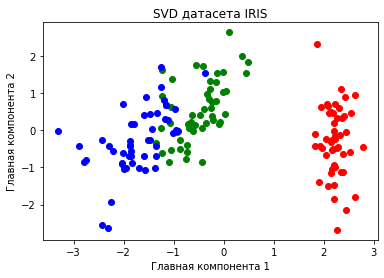

In [198]:
plt.figure()

for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y==i, 0], Z[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('SVD датасета IRIS')
plt.show()